In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# autoreload   
%load_ext autoreload
%autoreload 2

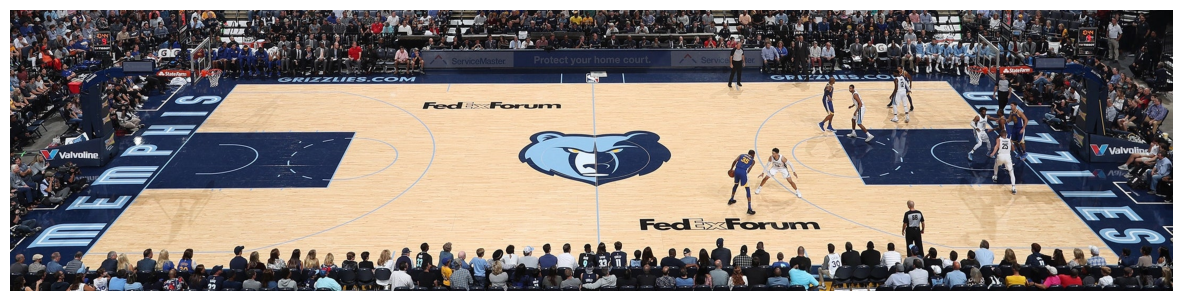

In [2]:
#Load the image
img = cv2.imread('./memphis.jpeg')
#Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#plot the image
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.axis('off')
plt.show()

# Feature extraction
In this section three ellipses are extracted from the image

In [3]:
def plot_points(points, color='r', label=None):
    """
    Plot points on the image.
    """
    plt.scatter(points[:, 0], points[:, 1], c=color, marker='x', label=label, s=10, linewidths=.5)

### Point selection (manual)

In [4]:
if False:
    %matplotlib tk
    # Display the image and allow the user to select points interactively
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Select points of the first circle')

    def select_points(obj_name:str, color='r'):
        """
        Function to select points on the image.
        :param obj_name: Name of the object to select points for.
        :return: List of selected points.
        """
        plt.title(f'Select points for {obj_name}')
        print(f"Please select points for {obj_name} and press Enter when done.")
        points = plt.ginput(n=-1, timeout=0)  # n=-1 allows unlimited points, timeout=0 waits indefinitely
        print(f"Selected points for {obj_name}:", points)

        plot_points(np.array(points), color=color, label=obj_name)
        plt.legend()
        return points

    # Use ginput to select points
    points_C1 = select_points("Circle 1", color='r')
    points_C2 = select_points("Circle 2", color='g')
    points_C3 = select_points("Circle 3", color='b')

    plt.close()

    %matplotlib inline
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Selected Points')
    plot_points(np.array(points_C1), color='r', label='Circle 1')
    plot_points(np.array(points_C2), color='g', label='Circle 2')
    plot_points(np.array(points_C3), color='b', label='Circle 3')
    plt.legend()
    plt.show()

    #Save the points to a file
    with open('selected_points.txt', 'w') as f:
        f.write("Circle 1:\n")
        for point in points_C1:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 2:\n")
        for point in points_C2:
            f.write(f"{point[0]}, {point[1]}\n")
        f.write("\nCircle 3:\n")
        for point in points_C3:
            f.write(f"{point[0]}, {point[1]}\n")

Loaded points for Circle 1: [[531.51612903 273.90388441]
 [566.98387097 319.22377688]
 [643.83064516 321.19420699]
 [714.76612903 297.5490457 ]
 [728.55913978 269.96302419]
 [671.41666667 246.3178629 ]
 [594.56989247 248.28829301]]
Loaded points for Circle 2: [[1004.41935484  285.72646505]
 [1144.31989247  315.28291667]
 [1199.49193548  295.57861559]
 [1181.75806452  254.19958333]
 [1051.70967742  248.28829301]
 [1018.21236559  262.08130376]
 [1102.94086022  240.40657258]]
Loaded points for Circle 3: [[1538.40591398  242.37700269]
 [1506.87903226  246.3178629 ]
 [1479.29301075  267.99259409]
 [1526.58333333  305.43076613]
 [1595.5483871   317.25334677]
 [1676.33602151  297.5490457 ]
 [1642.83870968  250.25872312]]


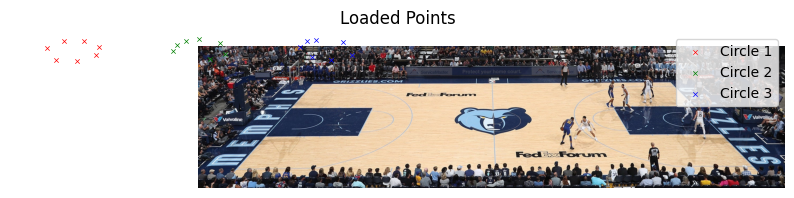

In [5]:
#Read points from the file
with open('selected_points.txt', 'r') as f:
    lines = f.readlines()
    points_C1 = []
    points_C2 = []
    points_C3 = []
    current_circle = None

    for line in lines:
        line = line.strip()
        if line.startswith("Circle 1:"):
            current_circle = points_C1
        elif line.startswith("Circle 2:"):
            current_circle = points_C2
        elif line.startswith("Circle 3:"):
            current_circle = points_C3
        elif line and current_circle is not None:
            x, y = map(float, line.split(','))
            current_circle.append((x, y))

    points_C1 = np.array(points_C1)
    points_C2 = np.array(points_C2)
    points_C3 = np.array(points_C3)

# Print the loaded points
print("Loaded points for Circle 1:", points_C1)
print("Loaded points for Circle 2:", points_C2)
print("Loaded points for Circle 3:", points_C3)

centerX = img.shape[1] // 2
centerY = img.shape[0] // 2
center = np.array([centerX, centerY])

# Center the points around the center of the image
points_C1 = points_C1 - center
points_C2 = points_C2 - center
points_C3 = points_C3 - center

%matplotlib inline
#Plot the loaded points
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Loaded Points')
plot_points(points_C1, color='r', label='Circle 1')
plot_points(points_C2, color='g', label='Circle 2')
plot_points(points_C3, color='b', label='Circle 3')
plt.legend()
plt.show()

### Fit Ellipse to points

In [6]:
from HomoTopiContinuation.DataStructures.datastructures import Conic, Conics, Homography

In [7]:
def getConic(x0, y0, MA, ma, theta):
    a = MA / 2
    b = ma / 2
    theta_rad = np.deg2rad(theta)
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    A = (c**2) / (a**2) + (s**2) / (b**2)
    B = 2 * c * s * (1/(a**2) - 1/(b**2))
    C = (s**2) / (a**2) + (c**2) / (b**2)
    D = -2*A*x0 - B*y0
    E = -2*C*y0 - B*x0
    F = A*x0**2 + B*x0*y0 + C*y0**2 - 1
    matrix = np.array([[A, B/2, D/2], [B/2, C, E/2], [D/2, E/2, F]])
    matrix /= matrix[0, 0]  # Normalize the matrix
    return Conic(matrix)

In [8]:
# Fit ellipses to the points using OpenCV
ellipse_C1 = cv2.fitEllipse(points_C1.astype(np.float32))
ellipse_C2 = cv2.fitEllipse(points_C2.astype(np.float32))
ellipse_C3 = cv2.fitEllipse(points_C3.astype(np.float32))

print("Ellipse parameters for Circle 1:", ellipse_C1)
print("Ellipse parameters for Circle 2:", ellipse_C2)
print("Ellipse parameters for Circle 3:", ellipse_C3)

#Convert the ellipses to matrix form
C1 = getConic(*ellipse_C1[0], *ellipse_C1[1], ellipse_C1[2])
C2 = getConic(*ellipse_C2[0], *ellipse_C2[1], ellipse_C2[2])
C3 = getConic(*ellipse_C3[0], *ellipse_C3[1], ellipse_C3[2])

print("Conic matrix for Circle 1:\n", C1.M)
print("Conic matrix for Circle 2:\n", C2.M)
print("Conic matrix for Circle 3:\n", C3.M)

Ellipse parameters for Circle 1: ((-472.96258544921875, 17.711416244506836), (77.74597930908203, 207.19589233398438), 85.92877197265625)
Ellipse parameters for Circle 2: ((7.162192344665527, 14.015918731689453), (77.73223876953125, 203.18211364746094), 89.32938385009766)
Ellipse parameters for Circle 3: ((483.3193359375, 11.934064865112305), (75.87483215332031, 205.82192993164062), 94.0590591430664)
Conic matrix for Circle 1:
 [[1.00000000e+00 4.19261383e-01 4.65536873e+02]
 [4.19261383e-01 6.86063318e+00 7.67834179e+01]
 [4.65536873e+02 7.67834179e+01 2.08409319e+05]]
Conic matrix for Circle 2:
 [[ 1.00000000e+00  6.82035020e-02 -8.11812709e+00]
 [ 6.82035020e-02  6.82607353e+00 -9.61621784e+01]
 [-8.11812709e+00 -9.61621784e+01 -8.90655869e+03]]
Conic matrix for Circle 3:
 [[ 1.00000000e+00 -4.35092173e-01 -4.78126918e+02]
 [-4.35092173e-01  7.10040422e+00  1.25551776e+02]
 [-4.78126918e+02  1.25551776e+02  2.19325965e+05]]


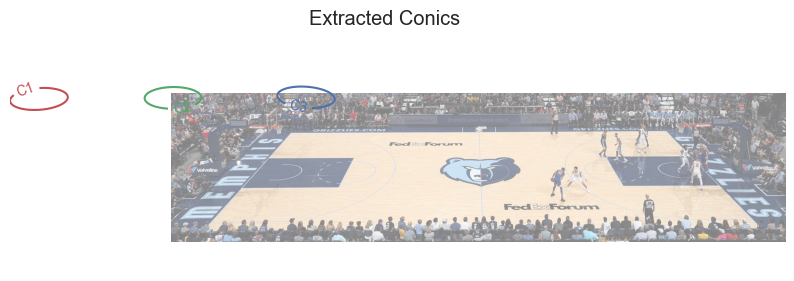

In [9]:
from HomoTopiContinuation.Plotter.Plotter import Plotter
plotter = Plotter(1, 1, title = "Extracted Conics", figsize=(10, 3))
plotter.newAxis(axisSame=False)
plotter.getCurrentAxis().imshow(img, alpha=0.5)
plotter.getCurrentAxis().axis('off')
plotter.getCurrentAxis().grid(False)
plotter.plotConic2D(C1, color='r', conicName="C1")
plotter.plotConic2D(C2, color='g', conicName="C2")
plotter.plotConic2D(C3, color='b', conicName="C3")
plotter.show()

# Rectification

In [39]:
from HomoTopiContinuation.Rectifier.homotopyc_rectifier import HomotopyContinuationRectifier
from HomoTopiContinuation.Rectifier.numeric_rectifier import NumericRectifier

rectifier = HomotopyContinuationRectifier()
H = rectifier.rectify(Conics(C1, C2, C3))
H.H /= H.H[2, 2]  # Normalize the homography matrix
H.H = np.real(H.H)  # Ensure the homography matrix is real-valued
print(H.H)

[[-0.70705864  0.00605438  0.        ]
 [ 0.01603035  1.87209761  0.        ]
 [ 0.          0.          1.        ]]


C1 warped:
C2 warped:
 [[ 1.99864404e+00 -1.38314648e-02 -1.53239745e+03]
 [-1.38314648e-02  1.94773233e+00 -1.04454417e+03]
 [-1.53239745e+03 -1.04454417e+03  1.73624116e+06]]
C3 warped:
 [[ 2.01592252e+00  3.68083051e-01 -1.07526234e+03]
 [ 3.68083051e-01  2.02353590e+00 -1.26349567e+03]
 [-1.07526234e+03 -1.26349567e+03  1.14539760e+06]]


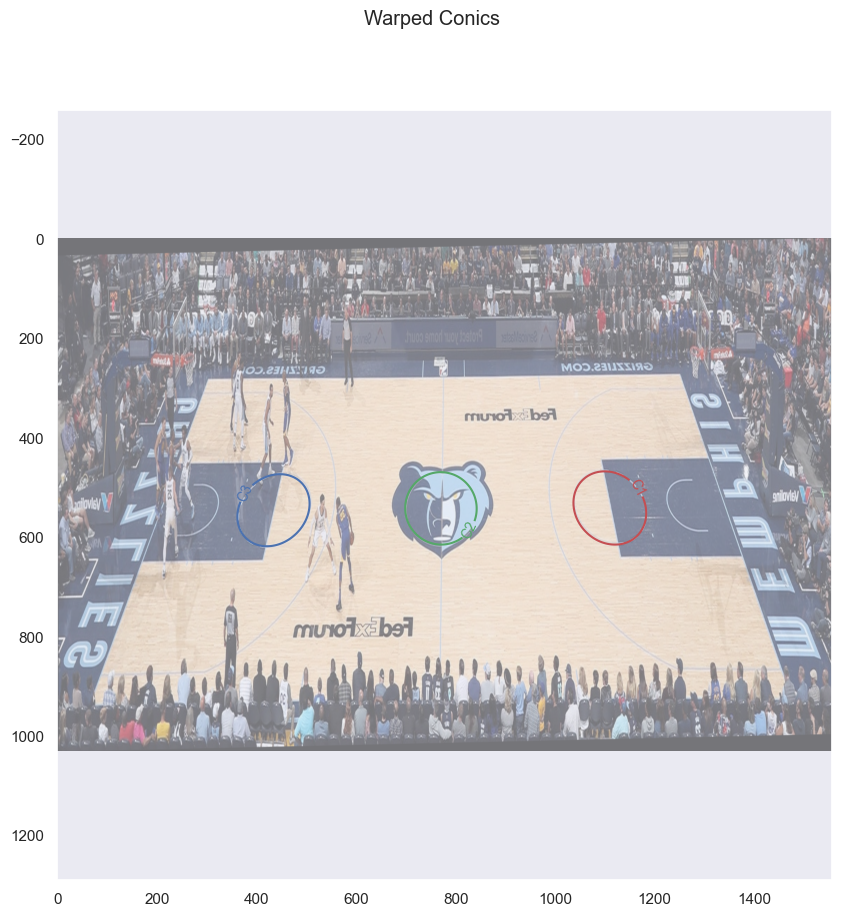

In [40]:
from HomoTopiContinuation.ImageWarper.ImageWarper import ImageWarper
warper = ImageWarper()
centering_transform = np.array([[1, 0, -centerX], [0, 1, -centerY], [0, 0, 1]])
H_centered = Homography(H.H @ centering_transform)
warped_img, adjH = ImageWarper()(img, H_centered)
centerX_warped = warped_img.shape[1] // 2
centerY_warped = warped_img.shape[0] // 2
centering_transform_post = np.array(
    [[1, 0, -centerX_warped], [0, 1, centerY_warped], [0, 0, 1]]
)
adjH = Homography(centering_transform_post@adjH)
# Rectify the conics using the homography
C1_warped = C1.applyHomography(adjH)
print("C1 warped:\n", C1_warped)
C2_warped = C2.applyHomography(adjH)
print("C2 warped:\n", C2_warped.M)
C3_warped = C3.applyHomography(adjH)
print("C3 warped:\n", C3_warped.M)

plotter = Plotter(1, 1, title = "Warped Conics", figsize=(10, 10))

plotter.newAxis(axisSame=True)
ax = plotter.getCurrentAxis()
ax.grid(False)
ax.imshow(warped_img, alpha=0.5)
plotter.plotConic2D(C1_warped, color='r', conicName="C1")
plotter.plotConic2D(C2_warped, color='g', conicName="C2")
plotter.plotConic2D(C3_warped, color='b', conicName="C3")

plotter.show()


In [41]:
from HomoTopiContinuation.Losser.CircleLosser import CircleLosser

CircleLosser.computeCircleLoss(None, Conics(C1_warped, C2_warped, C3_warped))

[np.float64(0.4978543984268594),
 np.float64(0.1701164565420902),
 np.float64(0.5552616014089206)]